This code is modified from the code at the below link.

https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb

## Part 0: Prerequisites:

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.8.0


## Classification of MNIST with Convolutional Neural Networks

Goal is to build a convolutional neural network (CNN) classifier to classify images of handwritten digits in the MNIST dataset.

In [2]:
# Set common constants
this_repo_url = 'https://github.com/lexfridman/mit-deep-learning/raw/master/'
this_tutorial_url = this_repo_url + 'tutorial_deep_learning_basics'

The MNIST dataset contains 70,000 grayscale images of handwritten digits at a resolution of 28 by 28 pixels. The task is to take one of these images as input and predict the most likely digit contained in the image (along with a relative confidence in this prediction):

Now, we load the dataset. The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The *labels* are an array of integers, ranging from 0 to 9.

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# reshape images to specify that it's a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

11501568/11490434 [==============================] - 0s 0us/step


We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [4]:
def preprocess_images(imgs): # should work for both a single image and multiple images
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape # make sure images are 28x28 and single-channel (grayscale)
    return imgs / 255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

Display the first 5 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

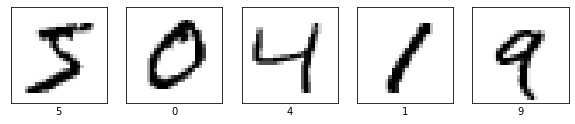

In [5]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model. In many cases, this can be reduced to simply stacking together layers:

In [6]:
model = keras.Sequential()
# 32 convolution filters used each of size 3x3
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 64 convolution filters used each of size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))
# choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
# flatten since too many dimensions, we only want a classification output
model.add(Flatten())
# fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
# one more dropout
model.add(Dropout(0.5))
# output a softmax to squash the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps. "accuracy" is the fraction of images that are correctly classified.

In [7]:
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_images` array. We verify that the predictions match the labels from the `test_labels` array. 

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [8]:
history = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 154s 81ms/step - loss: 0.1837 - accuracy: 0.9447
Epoch 2/5
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0786 - accuracy: 0.9767
Epoch 3/5
1875/1875 [==============================] - 147s 79ms/step - loss: 0.0597 - accuracy: 0.9818
Epoch 4/5
1875/1875 [==============================] - 148s 79ms/step - loss: 0.0496 - accuracy: 0.9846
Epoch 5/5
1875/1875 [==============================] - 148s 79ms/step - loss: 0.0411 - accuracy: 0.9874


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 98.68% on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [9]:
print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

(10000, 28, 28, 1)
313/313 [==============================] - 6s 19ms/step - loss: 0.0293 - accuracy: 0.9905
Test accuracy: 0.9904999732971191


Often times, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*. In our case, the accuracy is better at 99.19%! This is, in part, due to successful regularization accomplished with the Dropout layers.

In [10]:
test_predictions = model.predict(test_images)
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_labels, np.argmax(test_predictions,axis=1))
print(confusion)

[[ 975    0    1    0    0    0    2    0    1    1]
 [   0 1132    1    1    0    1    0    0    0    0]
 [   2    2 1020    1    0    0    0    6    1    0]
 [   0    0    1 1002    0    4    0    2    1    0]
 [   0    0    0    0  977    0    3    0    1    1]
 [   1    0    0    4    0  886    1    0    0    0]
 [   6    3    0    0    1    2  945    0    1    0]
 [   0    3    3    1    0    0    0 1020    1    0]
 [   3    1    3    1    0    1    0    2  959    4]
 [   1    1    0    0    7    3    0    5    3  989]]


## Acknowledgements

The contents of this tutorial is based on and inspired by the work of [TensorFlow team](https://www.tensorflow.org) (see their [Colab notebooks](https://www.tensorflow.org/tutorials/)), [MIT Human-Centered AI team](https://hcai.mit.edu), and individual pieces referenced in the [MIT Deep Learning](https://deeplearning.mit.edu) course slides.